In [1]:
import ROOT as rt
import numpy as np
import array
import plotLib.tdrstyle as tdrstyle
import plotLib.CMS_lumi as CMS_lumi
import re
import glob
import matplotlib.pyplot as plt
import array
%load_ext autoreload
%autoreload 2

tdrstyle.setTDRStyle()
rt.gStyle.SetOptStat(0)

Welcome to JupyROOT 6.18/02


In [2]:
def getXS(sample):
    with open("/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/data/all_bkg_back.list", "r") as xsfile:
        allxs = xsfile.readlines()
        for xs in allxs:
            if xs.split(' ')[0] in sample:
                return xs.split(' ')[-1].replace('\n','')
    print("[WARNING] {} cross section not found".format(sample))
    return 0

def extract_num(string):
    sample_num = list(map(int, re.findall(r'\d+', string.split('/')[-1])))
    if len(sample_num) > 1:
        sample_lambda, sample_ctau = sample_num[0], sample_num[1]
        if sample_ctau == 0:
            if "0_001cm" in string:
                sample_ctau = 0.001
            elif "0_01cm" in string:
                sample_ctau = 0.01
            elif "0_1cm" in string:
                sample_ctau = 0.1

        return sample_lambda, sample_ctau
    else:
        print("Can't extract number from {}".format(string))
        return 0, 0

def getSignalXS(sample):
    """Get cross section x BR for signal MC"""
    sample_lambda, sample_ctau = extract_num(sample)

    dat_file = "/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/data/XsecBR.dat"
    with open(dat_file, "r") as xsfile:
        allxs = xsfile.readlines()
        for xs in allxs[1:]:
            this_lambda, this_ctau = extract_num(xs)
            if sample_lambda == this_lambda and sample_ctau == this_ctau:
                return float(xs.split(' ')[4])
    print("[WARNING] {} cross section not found in {}".format(sample, dat_file))
    return 0

# Initialization

In [3]:
#indir = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output_fullbkg_cutBothPho/'
#indir = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output_baselineCut_noTrigger/'
indir = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/skim_legacy2016_diphoton/'
#data_name = indir+'/DelayedPhoton_DoubleEG_2016All_GoodLumi.root'
signal_name = indir+'/DelayedPhoton_GMSB_L-100TeV_Ctau-200cm_13TeV-pythia8.root'

filelist = glob.glob(indir+'/*.root')
signal_list = []

sample_list = {'DiPhoton': [],
               #'GJet': [],
               #'QCD': [],
              }

sample_color = {'DiPhoton': rt.kOrange-2,
                'GJet': rt.kAzure+1,
                'QCD': rt.kMagenta-7,
                'GMSB': rt.kBlack,
                'Data': rt.kBlack,
                'Z': rt.kAzure+10,
                'W': rt.kAzure+10,
                'T': rt.kAzure+10,
                'tt': rt.kAzure+10}

this_lambda, this_ctau = extract_num(signal_name)
sample_label = {
        'DiPhoton': '#gamma#gamma+jets',
        'GJet': '#gamma+jets',
        'QCD': 'QCD',
        'GMSB': 'GMSB #Lambda {}TeV c#tau {}cm'.format(this_lambda, this_ctau)
}

marker_style = {
    'DiPhoton': 20,
        'GJet': 20,
        'QCD': 20,
        'GMSB': 21,
}

features = ['pho1Pt', 'pho1Eta', 'HT_incPho', 'HT']
feature_xranges = {
        'HT_incPho': array.array('d', [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 700, 800, 950, 1200, 1500, 2000]),
        'HT': array.array('d', [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 700, 800, 950, 1200, 1500, 2000]),
        'pho1DNN': array.array('d', [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'pho1Pt': array.array('d', [70, 75, 80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160, 170, 180, 200, 220, 250, 300, 400]),
        'pho1Eta': array.array('d', [-1.4442, -1.2, -1, -0.7, -0.4, 0, 0.4, 0.7, 1, 1.2, 1.4442])
}

feature_names = {
    'HT': 'HT',
    'HT_incPho': 'HT including #gamma',
    'pho1DNN': '#gamma_{1} DNN score',
    'pho1Pt': '#gamma_{1} p^{T}',
    'pho1Eta': '#gamma_{1} #eta'
}


lumi_2016 = 35922.0
lumi_2017 = 41530.0
lumi = lumi_2016

triggers = {'Current': {}, 
            'Photon165': {}, 
            'HT500': {}
}

triggers['Current']['name'] = 'HLT_Photon42_R9Id85_OR_CaloId24b40e_Iso50T80L_Photon25_AND_HE10_R9Id65_Eta2_Mass15'
triggers['Current']['number'] = 81
triggers['Current']['last_filters'] = [4]

triggers['Photon165']['name'] = 'HLT_Photon165_HE10'
triggers['Photon165']['number'] = 102
triggers['Photon165']['last_filters'] = [36]

triggers['HT500']['name'] = 'HLT_Photon90_CaloIdL_PFHT500'
triggers['HT500']['number'] = 245
triggers['HT500']['last_filters'] = [37]


event_cut = 'n_Jets > 2 && n_Photons == 2'

MET_cut = " && Flag_HBHENoiseFilter == 1 \
            &&Flag_HBHEIsoNoiseFilter ==1 \
            && Flag_goodVertices == 1 \
            && Flag_eeBadScFilter == 1 \
            && Flag_EcalDeadCellTriggerPrimitiveFilter == 1 \
            && Flag_CSCTightHaloFilter == 1  \
            && Flag_badMuonFilter == 1 \
            && Flag_badGlobalMuonFilter == 0 \
            && Flag_duplicateMuonFilter ==0"

pho_cut = '&& pho1Pt > 70 && abs(pho1Eta)<1.4442 \
            && pho1passEleVeto \
            && pho1R9 > 0.85 && abs(pho1SigmaIetaIeta) < 0.024 '

# && abs(pho1ecalPFClusterIso) < 7.5 \
#             && abs(pho1hcalPFClusterIso) < 5.0 \
#             && abs(pho1trkSumPtHollowConeDR03) < 7.5 
# && abs(pho1HoverE) < 0.08 \
#             \

pho_cutbasedID = '&& pho1Pt > 70 \
                && pho1R9 > 0.9 \
                && abs(pho1Eta)<1.4442 \
                && pho1passEleVeto \
                && pho1Sminor<0.4 \
                && pho1passSigmaIetaIetaTight \
                && pho1passHoverETight \
                && pho1passSmajorTight \
                && pho1passIsoTight_comboIso'

pho2_cut = '&& pho2SigmaIetaIeta < 0.03 \
            && pho2HoverE < 0.1 \
            && pho2ecalPFClusterIso < 30.0 \
            && pho2sumNeutralHadronEt < 30.0 \
            && pho2trkSumPtHollowConeDR03 < 30.0'

baseline_cut = event_cut + pho_cut + MET_cut + pho2_cut
cut_based_id = event_cut + pho_cutbasedID + MET_cut + pho2_cut





# Create background list
for bkg in sample_list:
    for infile in filelist:
        if 'DelayedPhoton_{}'.format(bkg) in infile.split('/')[-1]:
            sample_list[bkg].append(infile)
            
# Append the signal
sample_list['GMSB'] = [signal_name]

In [4]:
baseline_cut

'n_Jets > 2 && n_Photons == 2&& pho1Pt > 70 && abs(pho1Eta)<1.4442             && pho1passEleVeto             && pho1R9 > 0.85 && abs(pho1SigmaIetaIeta) < 0.024  && Flag_HBHENoiseFilter == 1             &&Flag_HBHEIsoNoiseFilter ==1             && Flag_goodVertices == 1             && Flag_eeBadScFilter == 1             && Flag_EcalDeadCellTriggerPrimitiveFilter == 1             && Flag_CSCTightHaloFilter == 1              && Flag_badMuonFilter == 1             && Flag_badGlobalMuonFilter == 0             && Flag_duplicateMuonFilter ==0&& pho2SigmaIetaIeta < 0.03             && pho2HoverE < 0.1             && pho2ecalPFClusterIso < 30.0             && pho2sumNeutralHadronEt < 30.0             && pho2trkSumPtHollowConeDR03 < 30.0'

In [5]:
hist_pass = {}
hist_tot = {}
counter = {}
for fea in features:
    hist_pass[fea] = {}
    hist_tot[fea] = {}
    for sample in sample_list:
        if sample not in hist_pass[fea]:
            counter[sample] = 0
            hist_tot[fea][sample] = []
            hist_pass[fea][sample] = {}
            for trigger in triggers:
                hist_pass[fea][sample][trigger] = []
        for sample_file in sample_list[sample]:
            
            print("Reading {}".format(sample_file))
            if sample != 'GMSB':
                xs = getXS(sample_file.split('/')[-1])
            else:
                xs = getSignalXS(sample_file.split('/')[-1])
            
            tmp_file = rt.TFile.Open(sample_file, "READ")
            try:
                tmp_tree = tmp_file.Get("DelayedPhoton")
                tmp_sw = tmp_file.Get("SumWeights")
                sumWeights = tmp_sw.Integral()
            except:
                print("File is corrupted.")
                continue
            xsecOverSumweights = float(xs)/sumWeights
        
            #weight_selection = baseline_cut
            
            hist_tot_name = "hist_tot[{}][{}]{}".format(fea, sample, counter[sample])
            hist_tot[fea][sample].append(rt.TH1F(hist_tot_name,
                                         ";{}".format(feature_names[fea]),
                                         len(feature_xranges[fea])-1, 
                                         feature_xranges[fea]))
            hist_tot[fea][sample][-1].Sumw2()
            custom_cut = baseline_cut
            weight_selection = "({baseline_cut}) * (weight * \
                            pileupWeight * triggerEffSFWeight * \
                            photonEffSF * {lumi} * \
                            {xsecOverSumweights})".format(baseline_cut=custom_cut,
                                                    lumi=lumi,
                                                    xsecOverSumweights=xsecOverSumweights)
            draw_cmd = "{} >> {}".format(fea, hist_tot_name)
            tmp_tree.Draw(draw_cmd, weight_selection)
            hist_tot[fea][sample][-1].SetDirectory(0)

            
            ### Get different numerator histograms
            
            for trigger in triggers:

                hist_pass_name = "hist_pass[{}][{}][{}]{}".format(fea, sample, trigger, counter[sample])
                hist_pass[fea][sample][trigger].append(rt.TH1F(hist_pass_name,
                                             ";{}".format(feature_names[fea]),
                                             len(feature_xranges[fea])-1, 
                                             feature_xranges[fea]))
                hist_pass[fea][sample][trigger][-1].Sumw2()
                
                filter_pass = ''
                for last_fil in triggers[trigger]['last_filters']:
                    filter_pass += '(pho1passHLTFilter[{}] == 1)'.format(last_fil)
                if 'Current' in trigger:
                    filter_pass = '(pho1passHLTFilter[4] == 1)'
                weight_pass = "({}) * ({})".format(weight_selection, filter_pass)
                draw_cmd = "{}>>{}".format(fea, hist_pass_name)
                tmp_tree.Draw(draw_cmd, weight_pass)
                hist_pass[fea][sample][trigger][-1].SetDirectory(0)
                
            #if 'pho1DNN' not in fea:
            #    custom_cut = baseline_cut + ' && pho1DNN > 0.32'
            #else:
            
            
            tmp_file.Close()
            
            del tmp_tree, tmp_sw
            counter[sample] += 1

            
### Merging histograms (Pt bins, Mass bins etc)

print("Merging histograms")
sum_hist_pass = {}
sum_hist_tot = {}
for fea in features:
    sum_hist_pass[fea] = {}
    sum_hist_tot[fea] = {}
    for sample in sample_list:
        
        sum_hist_tot[fea][sample] = hist_tot[fea][sample][0]
        sum_hist_tot[fea][sample].Sumw2()
        
        sum_hist_pass[fea][sample] = {}
        
        for trigger in triggers:
            sum_hist_pass[fea][sample][trigger] = hist_pass[fea][sample][trigger][0]
            sum_hist_pass[fea][sample][trigger].Sumw2()
        
        if len(hist_tot[fea][sample]) > 1:
            
            for hist in hist_tot[fea][sample][1:]:
                sum_hist_tot[fea][sample].Add(hist)
            
            for trigger in triggers:
                for hist in hist_pass[fea][sample][trigger][1:]:
                    sum_hist_pass[fea][sample][trigger].Add(hist)

Reading /storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/skim_legacy2016_diphoton/DelayedPhoton_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
Reading /storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/skim_legacy2016_diphoton/DelayedPhoton_DiPhotonJetsBox_M40_80-Sherpa.root
Reading /storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/skim_legacy2016_diphoton//DelayedPhoton_GMSB_L-100TeV_Ctau-200cm_13TeV-pythia8.root
Reading /storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/skim_legacy2016_diphoton/DelayedPhoton_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
Reading /storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/skim_legacy2016_diphoton/DelayedPhoton_DiPhotonJetsBox_M40_80-Sherpa.root
Reading /storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/skim_legacy2016_diphoton//DelayedPhoton_GMSB_L-100Te

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already 

In [6]:
hist_tot[fea]

{'DiPhoton': [<ROOT.TH1F object ("hist_tot[HT][DiPhoton]0") at 0x5cf9210>,
  <ROOT.TH1F object ("hist_tot[HT][DiPhoton]1") at 0x619eed0>],
 'GMSB': [<ROOT.TH1F object ("hist_tot[HT][GMSB]0") at 0x5fbcfd0>]}

In [7]:
### Make ratio histogram
ratio_hist = {}
for fea in features:
    ratio_hist[fea] = {}
    for sample in sample_list:
        ratio_hist[fea][sample] = {}
        for trigger in triggers:
            ratio_hist[fea][sample][trigger] = sum_hist_pass[fea][sample][trigger].Clone()
            ratio_hist[fea][sample][trigger].Divide(sum_hist_tot[fea][sample])


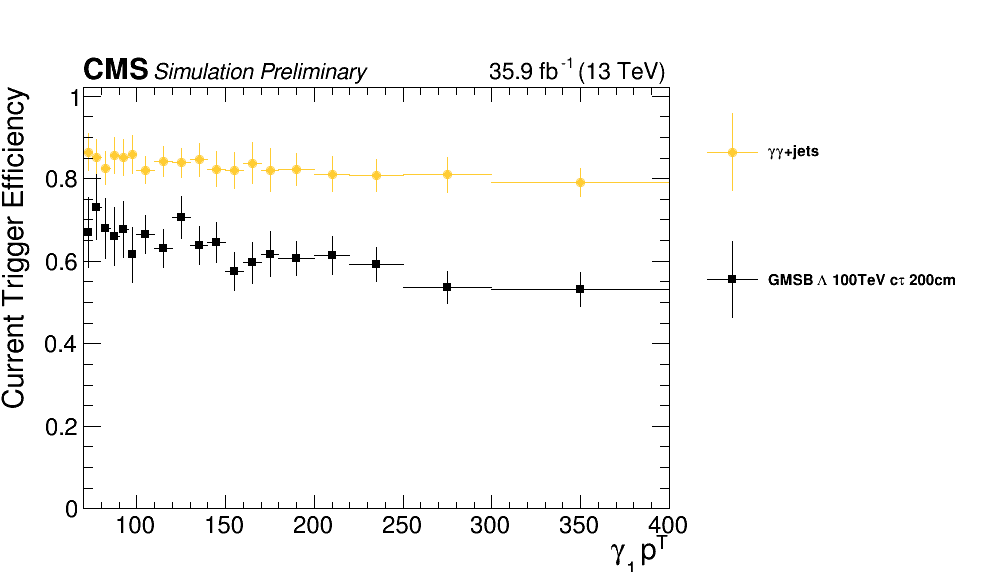

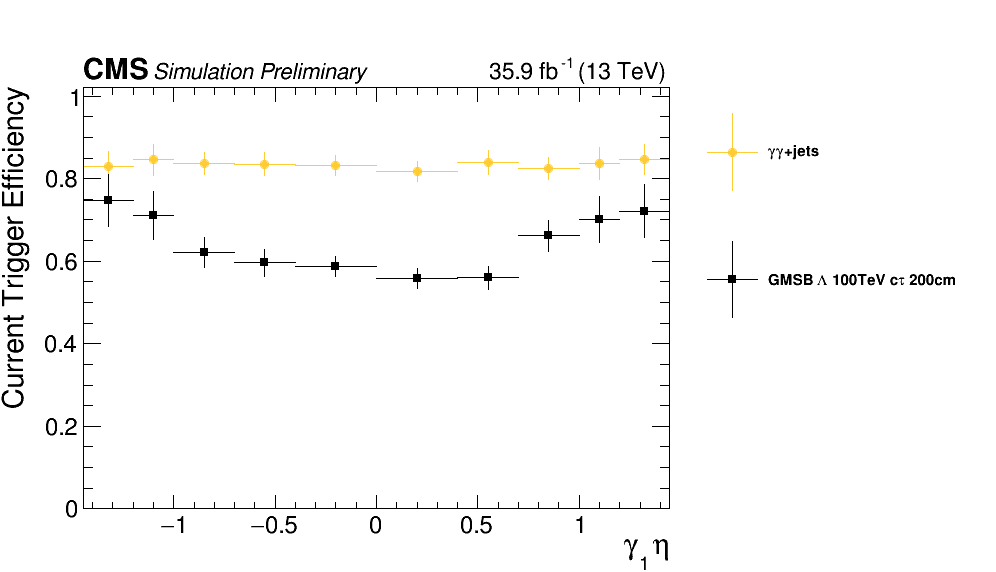

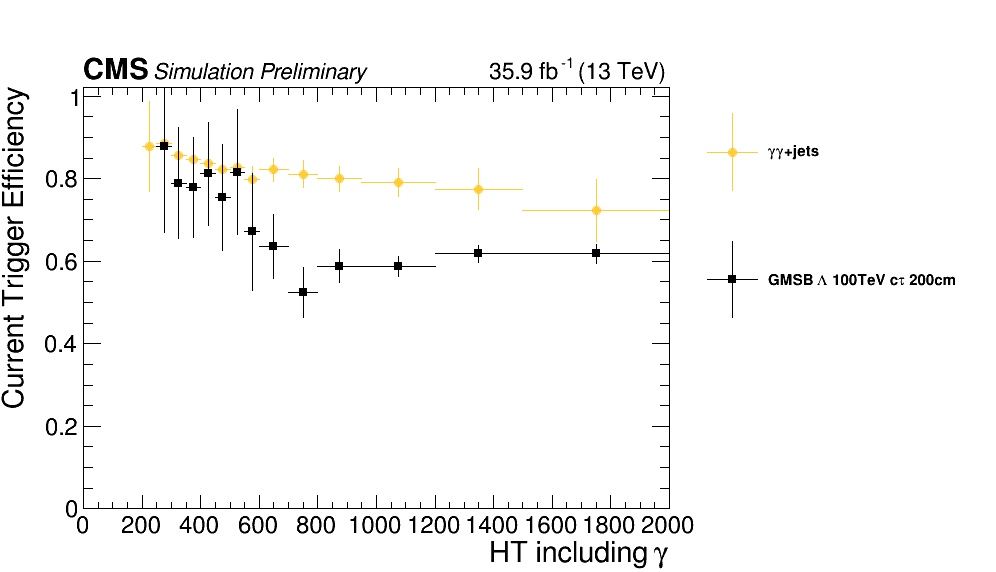

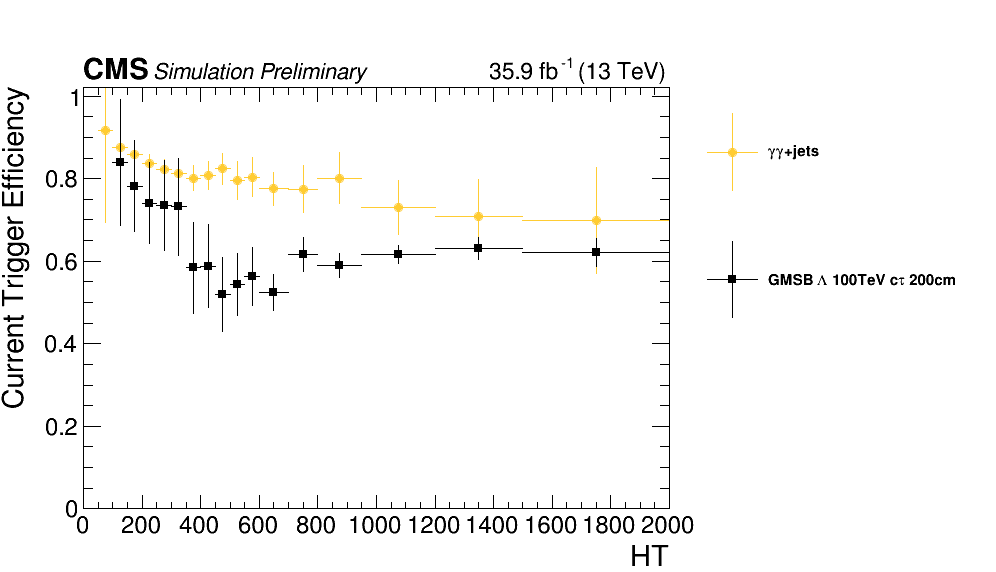

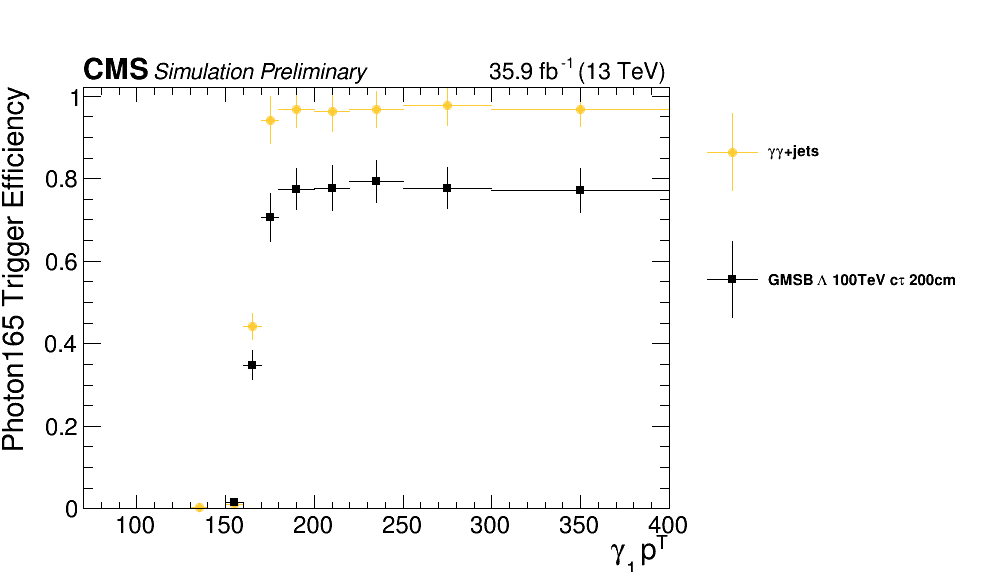

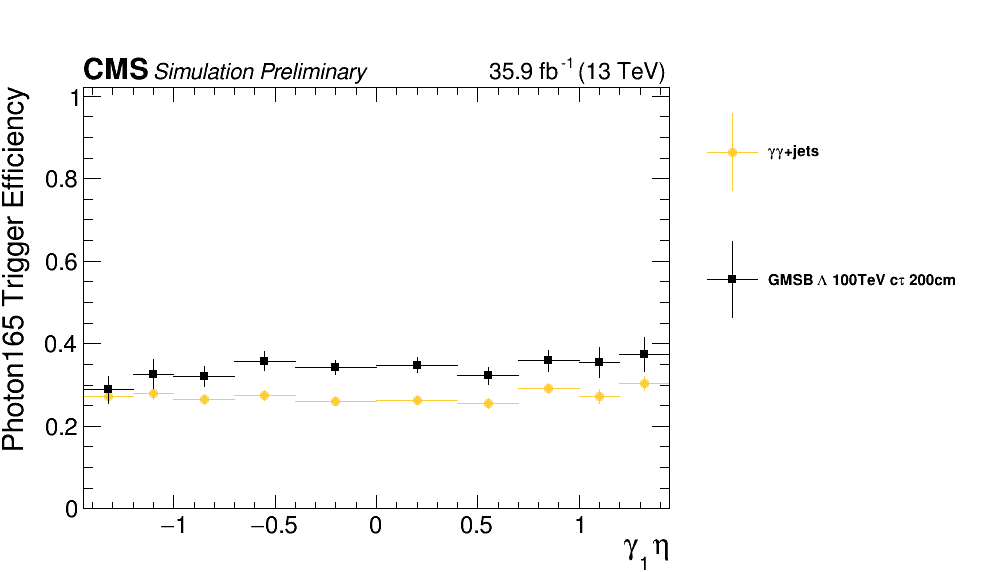

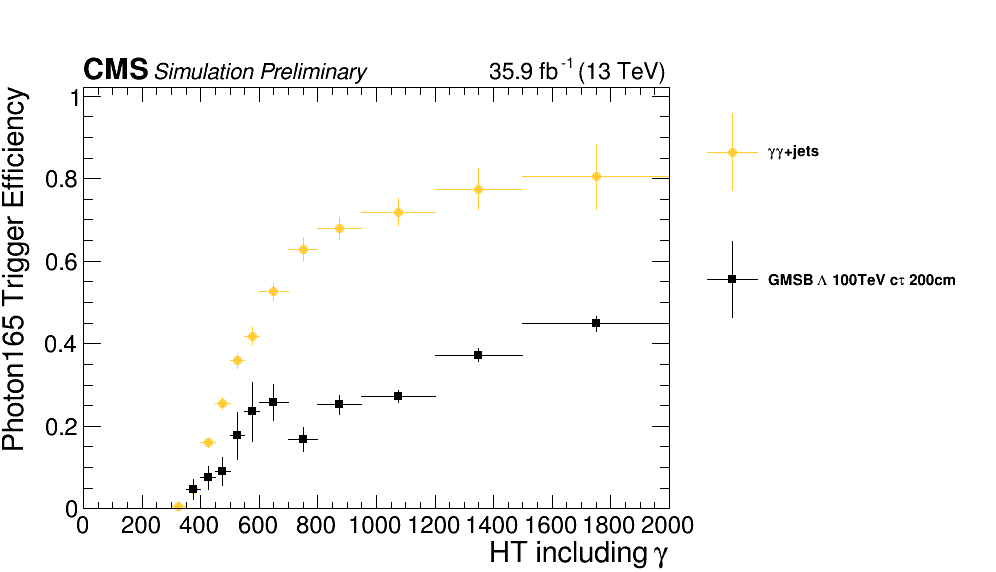

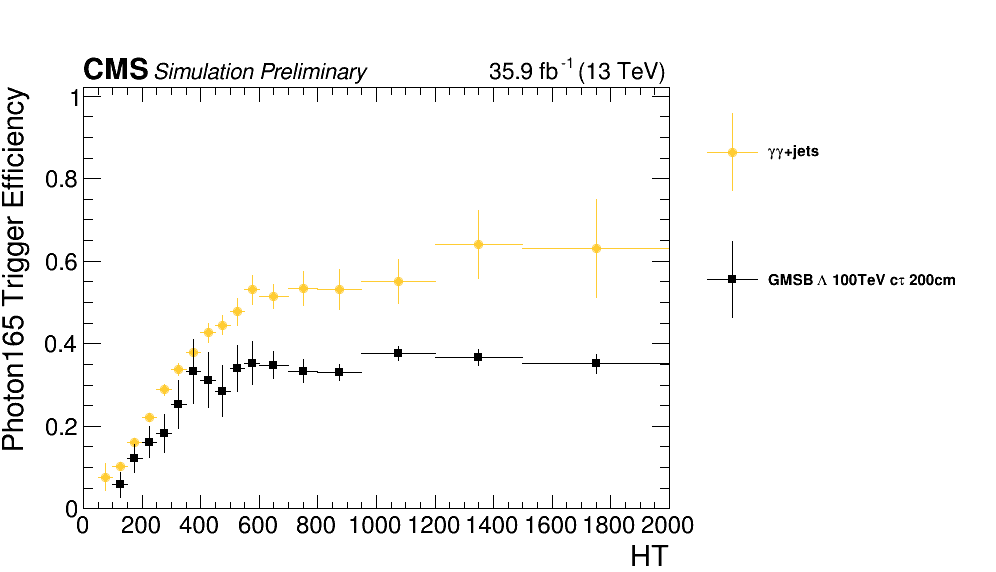

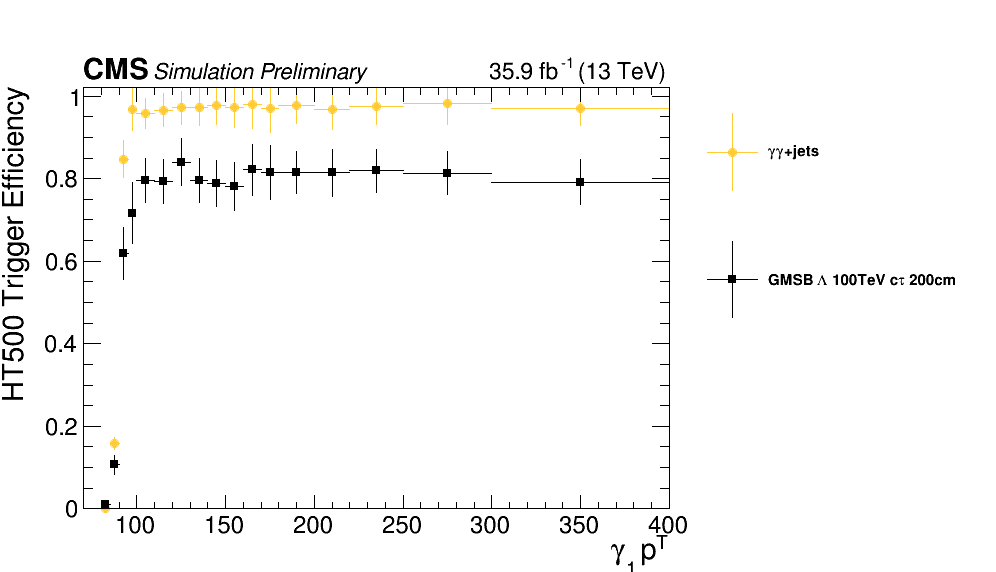

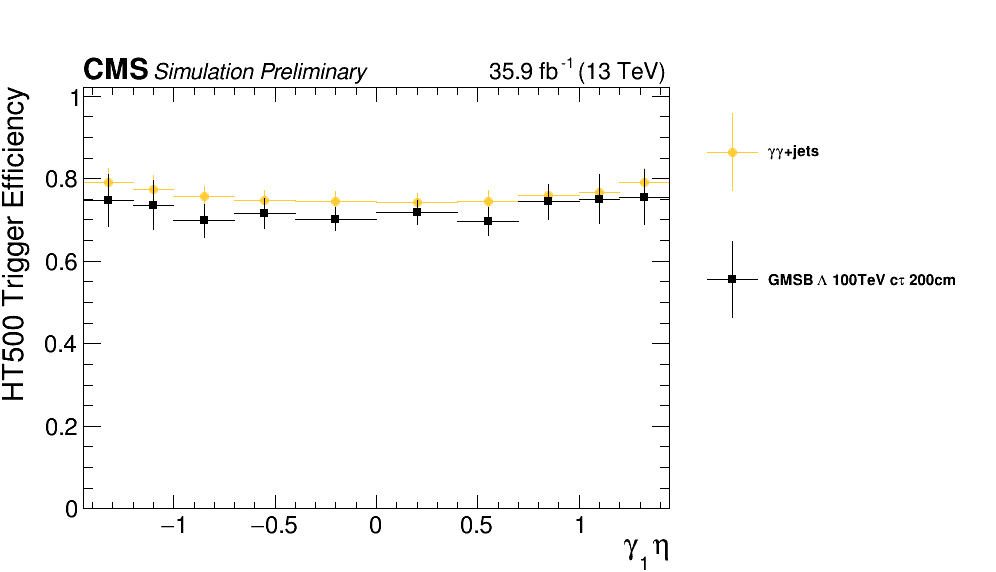

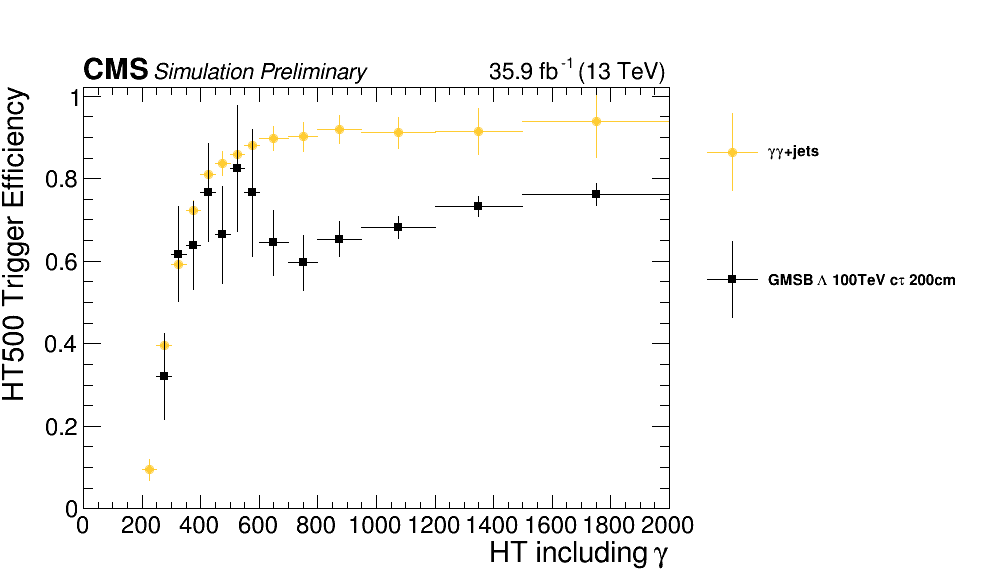

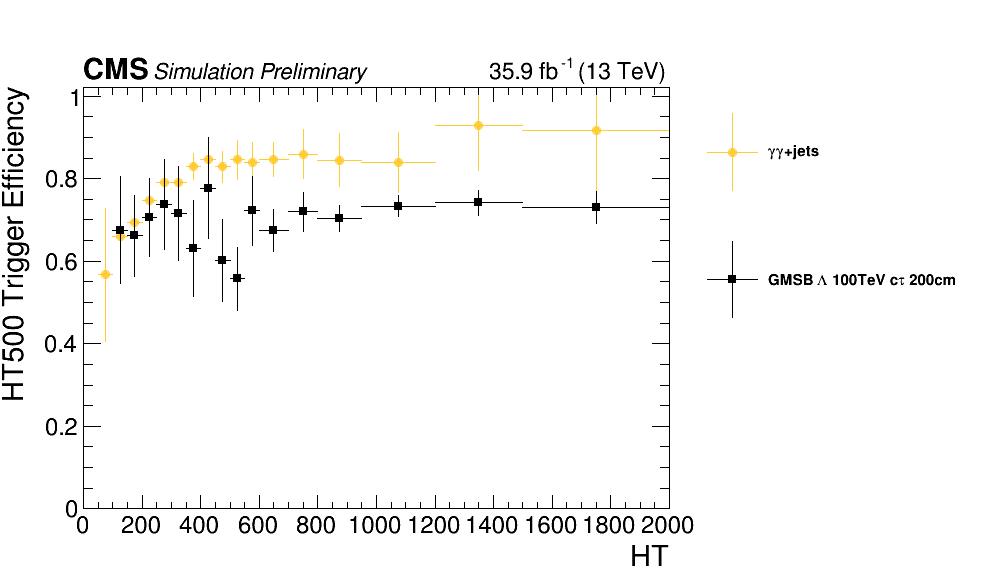

In [8]:
import plotLib.tdrstyle as tdrstyle
import plotLib.CMS_lumi as CMS_lumi

tdrstyle.setTDRStyle()

rt.gStyle.SetOptStat(0)
#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "Simulation Preliminary"
CMS_lumi.lumi_sqrtS = "35.9 fb^{-1} (13 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)

iPos = 0
if( iPos==0 ): 
    CMS_lumi.relPosX = 0.12

H_ref = 600;
W_ref = 1000;
W = W_ref
H  = H_ref
iPeriod = 0

# references for T, B, L, R
T = 0.08*H_ref
B = 0.12*H_ref
L = 0.12*W_ref
R = 0.04*W_ref
c1 = {}
pad1 = {}
pad2 = {}
leg = {}

for trigger in triggers:
    c1[trigger] = {}
    pad1[trigger] = {}
    pad2[trigger] = {}
    leg[trigger] = {}
    for i, fea in enumerate(features):
        c1[trigger][fea] = rt.TCanvas("c1[{}][{}][{}]".format(fea, sample, trigger),"",50, 50, W, H)
        c1[trigger][fea].cd()
        c1[trigger][fea].SetFillColor(0)
        c1[trigger][fea].SetBorderMode(0)
        c1[trigger][fea].SetFrameFillStyle(0)
        c1[trigger][fea].SetFrameBorderMode(0)

        c1[trigger][fea].SetTickx(0)
        c1[trigger][fea].SetTicky(0)
        rt.gStyle.SetOptStat(0)
        pad1[trigger][fea] = rt.TPad("pad1[{}][{}]".format(fea, trigger), "", 0, 0.0, 0.7, 0.92)
        pad1[trigger][fea].SetTopMargin(T/H)
        pad1[trigger][fea].SetLeftMargin(L/W)
        pad1[trigger][fea].SetRightMargin(R/W)
        pad1[trigger][fea].SetBottomMargin(B/H)
        pad1[trigger][fea].Draw()
        pad1[trigger][fea].cd()
        for k, sample in enumerate(sample_list):
            ratio_hist[fea][sample][trigger].GetYaxis().SetTitle("{} Trigger Efficiency".format(trigger))
            ratio_hist[fea][sample][trigger].GetYaxis().SetTitleOffset(1.02)
            ratio_hist[fea][sample][trigger].SetMinimum(0)
            ratio_hist[fea][sample][trigger].SetMaximum(1.02)
            ratio_hist[fea][sample][trigger].SetLineColor(sample_color[sample])
            ratio_hist[fea][sample][trigger].SetMarkerColor(sample_color[sample])
            ratio_hist[fea][sample][trigger].SetMarkerStyle(marker_style[sample])
            if k == 0:
                ratio_hist[fea][sample][trigger].Draw('lep')
            else:
                ratio_hist[fea][sample][trigger].Draw('lep same')
        c1[trigger][fea].Draw()
        CMS_lumi.CMS_lumi(pad1[trigger][fea], iPeriod, iPos)
        c1[trigger][fea].cd()
        pad2[trigger][fea] = rt.TPad("pad2[{}][{}]".format(fea, trigger), "", 0.7, 0.4, 0.99, 0.85);
        pad2[trigger][fea].SetTopMargin(0.0)
        pad2[trigger][fea].SetLeftMargin(0.0)
        pad2[trigger][fea].SetRightMargin(0.0)
        pad2[trigger][fea].SetBottomMargin(0.)
        pad2[trigger][fea].Draw()
        pad2[trigger][fea].cd()
        leg[trigger][fea] = rt.TLegend(0.0,0.,0.99,0.99)
        leg[trigger][fea].SetBorderSize(0)
        for sample in sample_list:
            leg[trigger][fea].AddEntry(ratio_hist[fea][sample][trigger], sample_label[sample], "lep")
        leg[trigger][fea].Draw()

        c1[trigger][fea].Update()
        c1[trigger][fea].RedrawAxis()


#### 

/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/skim_legacy2016_diphoton//DelayedPhoton_GMSB_L-100TeV_Ctau-200cm_13TeV-pythia8.root


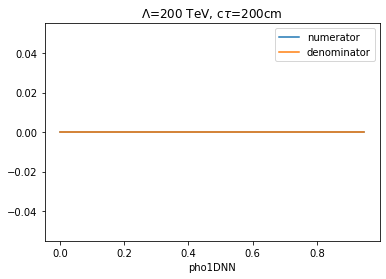

ValueError: x and y must have same first dimension, but have shapes (19,) and (0,)

Error in <TTreeFormula::Compile>:  Bad numerical expression : "pho1DNN"
Info in <TSelectorDraw::AbortProcess>: Variable compilation failed: {pho1DNN ,(n_Jets > 2 && n_Photons == 2&& pho1Pt > 70 && abs(pho1Eta)<1.4442             && pho1passEleVeto             && pho1R9 > 0.85 && abs(pho1SigmaIetaIeta) < 0.024  && Flag_HBHENoiseFilter == 1             &&Flag_HBHEIsoNoiseFilter ==1             && Flag_goodVertices == 1             && Flag_eeBadScFilter == 1             && Flag_EcalDeadCellTriggerPrimitiveFilter == 1             && Flag_CSCTightHaloFilter == 1              && Flag_badMuonFilter == 1             && Flag_badGlobalMuonFilter == 0             && Flag_duplicateMuonFilter ==0&& pho2SigmaIetaIeta < 0.03             && pho2HoverE < 0.1             && pho2ecalPFClusterIso < 30.0             && pho2sumNeutralHadronEt < 30.0             && pho2trkSumPtHollowConeDR03 < 30.0&& pho1Pt > 150 && pho1DNN > 0.0) * (weight *                         pileupWeight * triggerEffSFWeight *       

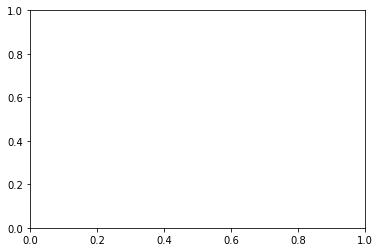

In [9]:
fea = 'pho1DNN'
sample = 'GMSB'
checkpoints = np.linspace(0, 1, 20)
efficiency = []
numerator = []
denominator = []

xs = getSignalXS(sample_file.split('/')[-1])
print(sample_file)
tmp_file = rt.TFile.Open(signal_name, "READ")
tmp_tree = tmp_file.Get("DelayedPhoton")
tmp_sw = tmp_file.Get("SumWeights")
sumWeights = tmp_sw.Integral()
xsecOverSumweights = float(xs)/sumWeights

for cp in checkpoints:
    tmp_hist = rt.TH1F("tmp_hist","",100,0,1)
    custom_cut = baseline_cut + '&& pho1Pt > 150 && pho1DNN > {}'.format(cp) 
    weight_selection = "({baseline_cut}) * (weight * \
                        pileupWeight * triggerEffSFWeight * \
                        photonEffSF * {lumi} * \
                        {xsecOverSumweights})".format(baseline_cut=custom_cut,
                                                    lumi=lumi,
                                                    xsecOverSumweights=xsecOverSumweights)
    tmp_tree.Draw("pho1DNN >> tmp_hist", weight_selection)
    denominator.append(tmp_hist.Integral())
    
    weight_pass = "({}) * (HLTDecision[81]==1)".format(weight_selection)
    tmp_tree.Draw("pho1DNN >> tmp_hist", weight_pass)
    numerator.append(tmp_hist.Integral())
    
for i in range(len(numerator)):
    if denominator[i]>0:
        efficiency.append(float(numerator[i]/denominator[i]))

plt.figure()
plt.plot(checkpoints[:-1], np.asarray(numerator)[:-1], label='numerator')
plt.plot(checkpoints[:-1], np.asarray(denominator)[:-1], label='denominator')
plt.legend(loc='best')
plt.xlabel('pho1DNN')
plt.title(r'$\Lambda$=200 TeV, c$\tau$=200cm')
plt.show()

plt.figure()
plt.plot(checkpoints[:-1], efficiency, label='ratio')
plt.legend(loc='best')
plt.xlabel('pho1DNN')
plt.show()